In [24]:
# Language Identification System
# Group No 33
# Mallikarachchi N.K (EG/2020/4067)    Manjula D.S (EG/2020/4070)

# Naïve Bayers Algorithm

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix
import joblib
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [3]:
train=pd.read_csv(r'data/dataset.csv')
df=train.copy()
df.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [4]:
df.shape

(22000, 2)

In [5]:
# Check if there is any duplicate rows
duplicate_rows = df[df.duplicated()]

# Display duplicate rows
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

Duplicate Rows:
                                                    Text    language
410    bisby fa roskov yr orrell tm nicolson d paglin...  Indonesian
581    haec commentatio automatice praeparata res ast...       Latin
1012   haec commentatio automatice praeparata res ast...       Latin
1027   bisby fa roskov yr orrell tm nicolson d paglin...  Indonesian
1460   haec commentatio automatice praeparata res ast...       Latin
...                                                  ...         ...
21427  seperti asteroid secara keseluruhan asteroid i...  Indonesian
21440  كباقي كويكبات معسكر الإغريق يقع مداره في النقط...      Arabic
21667  خواص - نسبتا اسيدي خواص لري په اوبو کى منحل دي...      Pushto
21739  இவ்வூர் கடல்மட்டத்தில் இருந்து சராசரியாக  மீட்...       Tamil
21743  haec commentatio automatice praeparata res ast...       Latin

[141 rows x 2 columns]


In [6]:
# delete duplicate rows
df = df.drop_duplicates()

In [7]:
# check if there are null values
df.isnull().sum()

Text        0
language    0
dtype: int64

In [8]:
# check the languages un dataset and their count
df['language'].value_counts()

language
Chinese       1000
Thai          1000
English       1000
Japanese      1000
Turkish       1000
Romanian      1000
Urdu          1000
Persian       1000
Korean        1000
Estonian       999
Russian        999
Arabic         998
Portugese      997
Spanish        996
Dutch          996
Pushto         993
Swedish        992
Hindi          990
French         990
Tamil          981
Indonesian     975
Latin          953
Name: count, dtype: int64

In [9]:
# check the no of languages in dataset
df['language'].value_counts().count()

22

In [10]:
# encording the language name to numerical values
x,y = df["Text"],df["language"]
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# save encoder in a file
with open('label_encoder.pkl', 'wb') as file:
    joblib.dump(encoder, file)

In [11]:
def preprocess(texts):
    cleanText = []
    for text in texts:
        cleaned_text = re.sub(f"[{re.escape(string.punctuation + '–' + string.digits)}]+", " ", text).lower()
        cleanText.append(cleaned_text)
    return cleanText

x = preprocess(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# making a matrix with words in training set
word_vectorizer = CountVectorizer(max_features=15000)
x_end_word_train = word_vectorizer.fit_transform(x_train).toarray()

# save word matrix in a file
with open('word_vectorizer.pkl', 'wb') as file:
    joblib.dump(word_vectorizer, file)


# making a matrix with characters in training set
char_vectorizer = CountVectorizer(analyzer='char', max_features=300)
x_end_char_train = char_vectorizer.fit_transform(x_train).toarray()

# save character matrix in a file
with open('char_vectorizer.pkl', 'wb') as file:
    joblib.dump(char_vectorizer, file)

# combine both matrixes in training set
x_combined_train = pd.DataFrame(np.hstack((x_end_word_train, x_end_char_train)))


In [12]:
# Apply the same vectorizers to the testing set
x_end_word_test = word_vectorizer.transform(x_test).toarray()
x_end_char_test = char_vectorizer.transform(x_test).toarray()

# combine both matrixes in testinng set
x_combined_test = pd.DataFrame(np.hstack((x_end_word_test, x_end_char_test)))

In [13]:
# Define the parameter distributions for randomized search
param_dist = {
    'alpha': stats.uniform(0.1, 1.5),
}

# Create the RandomizedSearchCV object
randomized_search = RandomizedSearchCV(BernoulliNB(), param_distributions=param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42)

# Fit the randomized search to the data
randomized_search.fit(x_combined_train, y_train)

# Print the best parameter
print("Best Parameters: ", randomized_search.best_params_)

Best Parameters:  {'alpha': 0.6618101782710437}


In [14]:
# Get the best model from the grid search
best_model = randomized_search.best_estimator_

# Use the optimized alpha value in the final model
model = BernoulliNB(alpha=best_model.alpha)
    
# Fit the model on the entire training data
model.fit(x_combined_train, y_train)

BernoulliNB(alpha=0.6618101782710437)

In [15]:
# evaluating model accuracy for testing set
def evalModel(cls,test_set):
    x,y = test_set
    y_pred = cls.predict(x)
    conf_matrix = confusion_matrix(y_pred=y_pred,y_true=y)
    acc = (accuracy_score(y_pred=y_pred,y_true=y)) * 100
    
    print(f"Accuracy is {acc}%")
    plt.subplots(figsize=(17,10))
    sns.heatmap(conf_matrix,annot=True,fmt=".1f",linewidths=1.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Accuracy is 98.01006404391582%


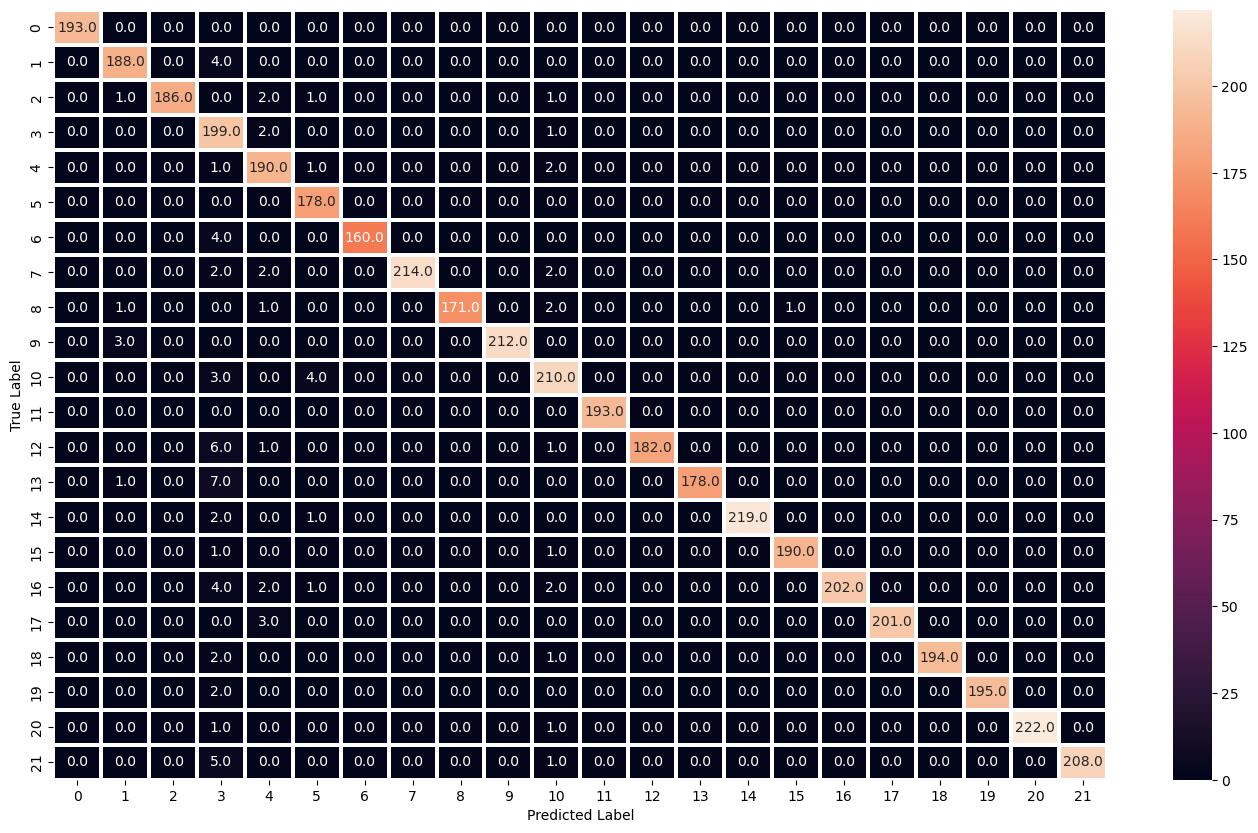

In [16]:
evalModel(model,(x_combined_test,y_test))

In [17]:
# Load the saved char vectorizer
with open('char_vectorizer.pkl', 'rb') as file:
    loaded_char_vectorizer = joblib.load(file)

# Load the saved word vectorizer
with open('word_vectorizer.pkl', 'rb') as file:
    loaded_word_vectorizer = joblib.load(file)

# New data to be predicted
new_data = ["Machine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems.",
            "머신러닝은 인공 지능의 하위 분야로, 지능적인 인간 행동을 모방하는 기계의 능력으로 광범위하게 정의됩니다. 인공지능 시스템은 인간이 문제를 해결하는 방식과 유사한 방식으로 복잡한 작업을 수행하는 데 사용됩니다.",
            "机器学习是人工智能的一个子领域，广义上定义为机器模仿人类智能行为的能力。人工智能系统用于以类似于人类解决问题的方式执行复杂的任务",
            "Apparatus eruditionis est subfield intelligentiae artificialis, quae late definitur facultas machinae ad mores humanos intelligentes imitandi. Systemata intelligentiae artificialis adhibita ad multiplicia officia exercenda eo modo, quo homines problemata solvent.",
            "การเรียนรู้ของเครื่องเป็นสาขาย่อยของปัญญาประดิษฐ์ ซึ่งถูกกำหนดอย่างกว้างๆ ว่าเป็นความสามารถของเครื่องจักรในการเลียนแบบพฤติกรรมที่ชาญฉลาดของมนุษย์ ระบบปัญญาประดิษฐ์ถูกใช้เพื่อทำงานที่ซับซ้อนในลักษณะที่คล้ายคลึงกับวิธีที่มนุษย์แก้ปัญหา",]

# Preprocess the new data
cleaned_text = preprocess(new_data)

# Transform the new data
new_data_word = loaded_word_vectorizer.transform(cleaned_text).toarray()
new_data_char = loaded_char_vectorizer.transform(cleaned_text).toarray()

# Combine character and word features horizontally
new_data_combined = pd.DataFrame(np.hstack((new_data_word, new_data_char)))

# Make predictions
predictions = model.predict(new_data_combined)

# Display predictions
for text, prediction in zip(new_data, predictions):
    print(f"Text: {text}\nPredicted Language: {encoder.inverse_transform([prediction])[0]}\n")



Text: Machine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems.
Predicted Language: English

Text: 머신러닝은 인공 지능의 하위 분야로, 지능적인 인간 행동을 모방하는 기계의 능력으로 광범위하게 정의됩니다. 인공지능 시스템은 인간이 문제를 해결하는 방식과 유사한 방식으로 복잡한 작업을 수행하는 데 사용됩니다.
Predicted Language: Korean

Text: 机器学习是人工智能的一个子领域，广义上定义为机器模仿人类智能行为的能力。人工智能系统用于以类似于人类解决问题的方式执行复杂的任务
Predicted Language: Chinese

Text: Apparatus eruditionis est subfield intelligentiae artificialis, quae late definitur facultas machinae ad mores humanos intelligentes imitandi. Systemata intelligentiae artificialis adhibita ad multiplicia officia exercenda eo modo, quo homines problemata solvent.
Predicted Language: Latin

Text: การเรียนรู้ของเครื่องเป็นสาขาย่อยของปัญญาประดิษฐ์ ซึ่งถูกกำหนดอย่างกว้างๆ ว่าเป็นความสามารถของเครื่องจักรในการเลียนแบบพฤติกรรมที่ชาญฉลา

# KNN Algorithm

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [19]:
param_dist = {
    'n_neighbors': stats.randint(1, 15),
}

# Create the RandomizedSearchCV object
randomized_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42)

x_combined_train_array = x_combined_train.values

# Fit the randomized search to the data
randomized_search.fit(x_combined_train_array, y_train)

# Print the best parameter
print("Best Parameters: ", randomized_search.best_params_)

Best Parameters:  {'n_neighbors': 13}


In [20]:
# Get the best model from the grid search
best_model = randomized_search.best_estimator_

# Use the optimized n_neighbors value in the final model
knn_model = KNeighborsClassifier(n_neighbors=best_model.n_neighbors)


# Fit the best model on the entire training data
knn_model.fit(x_combined_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [21]:
# evaluating model accuracy for testing set
def evalModel(cls,test_set):
    x, y = test_set
    x_array = x.values if isinstance(x, pd.DataFrame) else x
    y_pred = cls.predict(x_array)
    conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y)
    acc = round(accuracy_score(y_pred=y_pred, y_true=y), 2) * 100

    print(f"Accuracy is {acc}%")
    plt.subplots(figsize=(17, 10))
    sns.heatmap(conf_matrix, annot=True, fmt=".1f", linewidths=1.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Accuracy is 95.0%


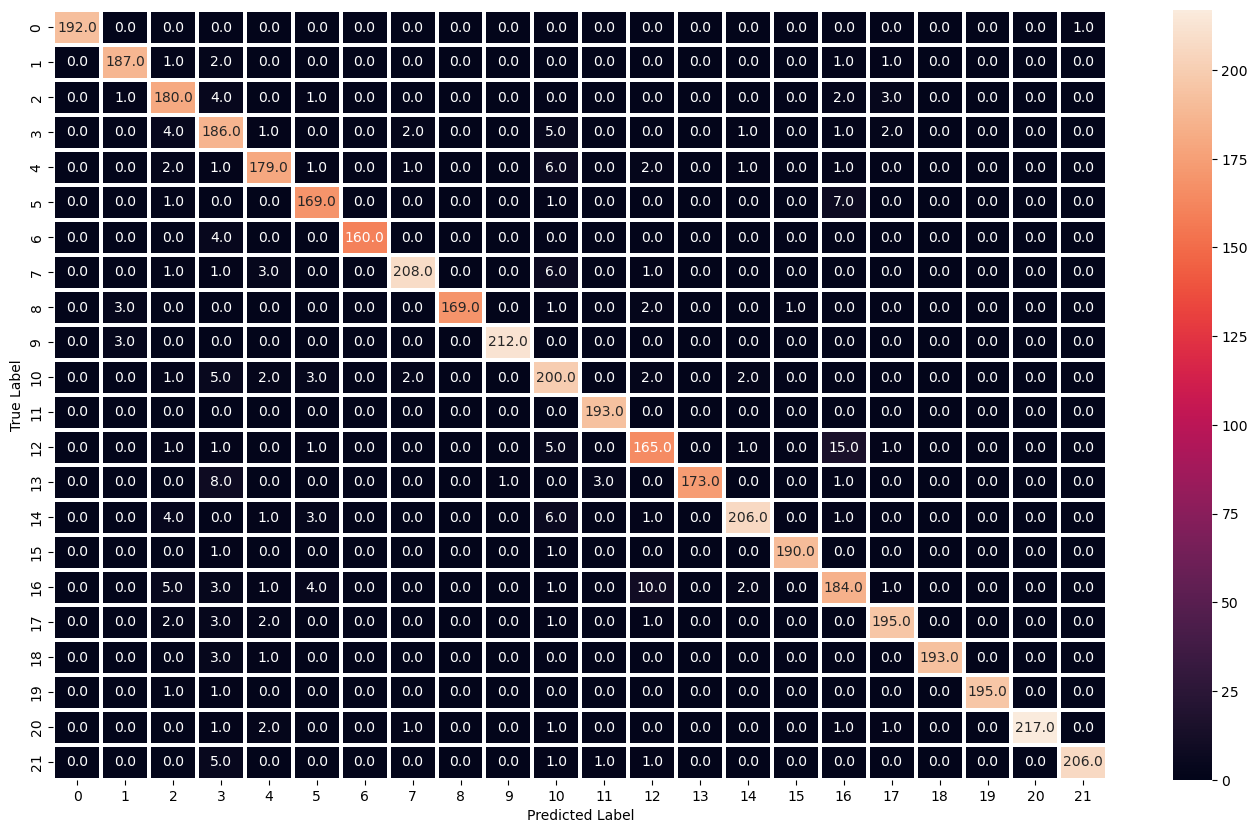

In [22]:
evalModel(knn_model, (x_combined_test, y_test))

In [23]:
# Load the saved vectorizers
with open('char_vectorizer.pkl', 'rb') as file:
    loaded_char_vectorizer = joblib.load(file)

# Load the saved word vectorizer and vocabulary
with open('word_vectorizer.pkl', 'rb') as file:
    loaded_word_vectorizer = joblib.load(file)

# New data to be transformed
new_data = ["Machine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems.",
            "머신러닝은 인공 지능의 하위 분야로, 지능적인 인간 행동을 모방하는 기계의 능력으로 광범위하게 정의됩니다. 인공지능 시스템은 인간이 문제를 해결하는 방식과 유사한 방식으로 복잡한 작업을 수행하는 데 사용됩니다.",
            "机器学习是人工智能的一个子领域，广义上定义为机器模仿人类智能行为的能力。人工智能系统用于以类似于人类解决问题的方式执行复杂的任务",
            "Apparatus eruditionis est subfield intelligentiae artificialis, quae late definitur facultas machinae ad mores humanos intelligentes imitandi. Systemata intelligentiae artificialis adhibita ad multiplicia officia exercenda eo modo, quo homines problemata solvent.",
            "การเรียนรู้ของเครื่องเป็นสาขาย่อยของปัญญาประดิษฐ์ ซึ่งถูกกำหนดอย่างกว้างๆ ว่าเป็นความสามารถของเครื่องจักรในการเลียนแบบพฤติกรรมที่ชาญฉลาดของมนุษย์ ระบบปัญญาประดิษฐ์ถูกใช้เพื่อทำงานที่ซับซ้อนในลักษณะที่คล้ายคลึงกับวิธีที่มนุษย์แก้ปัญหา",]

# Preprocess the new data
cleaned_text = preprocess(new_data)

# Transform the new data using the loaded vectorizers
new_data_word = loaded_word_vectorizer.transform(cleaned_text).toarray()
new_data_char = loaded_char_vectorizer.transform(cleaned_text).toarray()

# Combine character and word features horizontally
new_data_combined = pd.DataFrame(np.hstack((new_data_word, new_data_char)))
# Make predictions and get probability scores on the new data
new_data_combined_values = new_data_combined.values if isinstance(new_data_combined, pd.DataFrame) else new_data_combined
predictions = knn_model.predict(new_data_combined_values)

# Display the predicted language and corresponding probability scores for the new data
for text, prediction in zip(new_data, predictions):
    print(f"Text: {text}\nPredicted Language: {encoder.inverse_transform([prediction])[0]}\n")


Text: Machine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems.
Predicted Language: English

Text: 머신러닝은 인공 지능의 하위 분야로, 지능적인 인간 행동을 모방하는 기계의 능력으로 광범위하게 정의됩니다. 인공지능 시스템은 인간이 문제를 해결하는 방식과 유사한 방식으로 복잡한 작업을 수행하는 데 사용됩니다.
Predicted Language: Korean

Text: 机器学习是人工智能的一个子领域，广义上定义为机器模仿人类智能行为的能力。人工智能系统用于以类似于人类解决问题的方式执行复杂的任务
Predicted Language: Chinese

Text: Apparatus eruditionis est subfield intelligentiae artificialis, quae late definitur facultas machinae ad mores humanos intelligentes imitandi. Systemata intelligentiae artificialis adhibita ad multiplicia officia exercenda eo modo, quo homines problemata solvent.
Predicted Language: Latin

Text: การเรียนรู้ของเครื่องเป็นสาขาย่อยของปัญญาประดิษฐ์ ซึ่งถูกกำหนดอย่างกว้างๆ ว่าเป็นความสามารถของเครื่องจักรในการเลียนแบบพฤติกรรมที่ชาญฉลา